<a href="https://colab.research.google.com/github/alanapogostin/57th_Building_Viewer/blob/master/FRESH_Program.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Analysis requirements
on top of general assignment requirements

Read like a blog post
Pretend you're explaining to a Wagner student who hasn't taken this class. You don't need to teach them Python, but they should be able to follow what's going on.
Re-state the question, hypothesis, and data source(s) with link(s)
Walk the reader through what you're doing in every step and what they should be taking away from it.
Markdown can be used in text cells for formatting.
Include any dead ends you hit.
Have a conclusion that speaks to your question and hypothesis.
Use pandas
Not be trivial, requiring:
At least 40 lines of code to come to a conclusion
Transforming data through grouping, merging, and/or reshaping of DataFrames
Operations that aren't easily done in a spreadsheet.
Have a visualization (chart or map) of some kind
Don't leave any sensitive information in the notebook: API keys, personally-identifiable information (PII), etc.

**And the analysis begins....**

Like all code, I need to set up my environment by pulling in all relevant pacakges.

In [90]:
import pandas as pd
import plotly.express as px
import numpy as np
import requests
#%pip install --upgrade --quiet plotly
%pip install geopandas
import geopandas as gpd
#%pip install Point
from shapely.geometry import Point
%pip install --upgrade --quiet plotly
%pip install --upgrade --quiet geopandas

# Importing and Cleaning Data
**Now I need to import all my data.**
I am going to start with importing all of the shape boundaries.

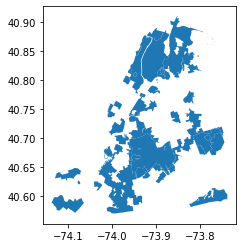

In [91]:
fresh = gpd.read_file('https://data.cityofnewyork.us/api/geospatial/w9uz-8epq?method=export&format=GeoJSON')
fresh = fresh.to_crs(epsg=4326)
fresh.plot()

### FRESH Program Boundary

The original FRESH program study was only looking at supermarkets that are 10,000 square feet or less. So after I pull in the supermarket data in NYC from the data.ny.gov API I filtered out supermarkets that are 10,000 square feet or more. 

In [92]:
retrieve = requests.get("https://data.ny.gov/resource/9a8c-vfzj.geojson?$query=SELECT * WHERE county='Bronx' OR county='Queens' OR county='Kings'OR county='Richmond' OR county='New York' LIMIT 10000000")
grocery_stores = retrieve.json()
grocery_stores = pd.json_normalize(grocery_stores['features']) 
grocery_stores['properties.square_footage'] = grocery_stores['properties.square_footage'].astype(int)
grocery_stores = grocery_stores[(grocery_stores['properties.square_footage'] >= 10000)& (grocery_stores['geometry.coordinates'].isna() == False)]

Since I am doing some relatively complex geospatial calculations, I am going to convert the "grocery_stores" dataframe into a geospatial dataframe using the geopandas package.

In [ ]:
grocery_stores['geometry'] = grocery_stores['geometry.coordinates'].apply(Point)
grocery_stores_gpd = gpd.GeoDataFrame(grocery_stores, geometry='geometry')
grocery_stores_gpd = grocery_stores_gpd['properties.square_footage', 'type', 'geometry']
grocery_stores_gpd.head(3)

In [ ]:
grocery_stores_gpd.plot()

### Community District Shape and Population

To create any form of chloropleth map showing data by NYC community district, I need to pull in the community district shape file. 

In [94]:
cd_shape = 'https://data.cityofnewyork.us/api/geospatial/yfnk-k7r4?method=export&format=GeoJSON'
cd_shape_gpd = gpd.read_file(cd_shape, crs = "epsg:4326")
pop_by_cd_geojson = pop_by_cd.get(cd_shape)
cd_shape_gpd

,boro_cd,shape_area,shape_leng,geometry
0,101,42689119.0133,74168.5878924,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ..."
1,102,37689205.9401,34130.5952768,"MULTIPOLYGON (((-73.99684 40.73736, -73.99362 ..."
2,103,46879779.2986,30695.6409632,"MULTIPOLYGON (((-73.97177 40.72582, -73.97179 ..."
3,104,49311715.1126,67623.6699012,"MULTIPOLYGON (((-73.99394 40.77318, -73.99370 ..."
4,105,43790329.8699,35288.1885095,"MULTIPOLYGON (((-73.97301 40.76428, -73.97141 ..."
...,...,...,...,...
66,502,592715674.432,143044.989836,"MULTIPOLYGON (((-74.07347 40.57839, -74.07345 ..."
67,503,599053419.389,193564.186317,"MULTIPOLYGON (((-74.13320 40.53631, -74.13301 ..."
68,595,54734567.3489,110147.254437,"MULTIPOLYGON (((-74.11834 40.55046, -74.11676 ..."
69,203,44803080.7253,33500.8967412,"MULTIPOLYGON (((-73.88072 40.83752, -73.88074 ..."


Now, I am going to pull in the population data from [NYC Open data](https://opendata.cityofnewyork.us/)  .

In [95]:
pop_by_cd = pd.read_csv('https://data.cityofnewyork.us/api/views/xi7c-iiu2/rows.csv')

To join the population data in "pop_by_cd" to the community district boundary layer, I am going to need a column to join on. Right how "pop_by_cd" has the Community District numbers and the Boroughs. I am going to use this information to generate the community district code so it matches the "boro_cd" column in "cd_shape_gpd". 

To create the "boro_cd" column, I am going to define a funtion that uses CD Number and Borough to create the "boro_ce".

In [96]:
def borocd_code(row):
  if "Manhattan" in row["Borough"]:
    return '1'  + format(row["CD Number"], '02')
  elif "Bronx" in row["Borough"]:
    return '2' + format(row["CD Number"], '02')
  elif "Brooklyn" in row["Borough"]:
    return '3' + format(row["CD Number"], '02')
  elif "Queens" in row["Borough"]:
    return '4' + format(row["CD Number"], '02')
  elif "Staten Island" in row["Borough"]:
    return '5' + format(row["CD Number"], '02')
  else:
    return 'In'

Now I am running the function on the df to create a the "boro_cd" column.

In [97]:
pop_by_cd['boro_cd'] = pop_by_cd.apply(borocd_code, axis = 1)

# Geospatial Manipulation

Before I do any geospatial transformations, I want to make sure that the coordinate reference systems of the two geodataframes match eachother.

In [98]:
grocery_stores_gpd = grocery_stores_gpd.set_crs(epsg=4326)
cd_shape_gpd = cd_shape_gpd.set_crs(4326) 
grocery_stores_gpd.crs == cd_shape_gpd.crs

,type,geometry,properties.location_state,properties.estab_type,properties.zip_code,properties.city,properties.location_zip,properties.operation_type,properties.state,properties.location_address,properties.address_line_3,properties.location_city,properties.street_name,properties.dba_name,properties.county,properties.entity_name,properties.square_footage,properties.address_line_2,properties.street_number,properties.license_number,geometry.type,geometry.coordinates
27,Feature,POINT (-73.90016 40.82316),NY,A,10459,BRONX,10459,Store,NY,985 PROSPECT AVE,,BRONX,PROSPECT AVE,LUCKY 99 CENTS SHOP,Bronx,LUCKY 99 CENTS SHOP INC,10000,,985,609443,Point,"[-73.900161, 40.82316]"
46,Feature,POINT (-73.96430 40.62047),NY,JAC,11230,BROOKLYN,11230,Store,NY,1507 CONEY ISLAND AVE,,BROOKLYN,CONEY ISLAND AVE,POMEGRANATE,Kings,KOSHER GARDEN INC THE,18000,,1507,616354,Point,"[-73.964303, 40.620473]"
52,Feature,POINT (-73.95836 40.60573),NY,JAC,11229,BROOKLYN,11229,Store,NY,1406 AVENUE,,BROOKLYN,AVENUE U,AVE U FISH MARKET,Kings,AVE U FISH MARKET INC,25000,,1406,730294,Point,"[-73.95836, 40.605729]"
88,Feature,POINT (-73.90687 40.66964),NY,JAC,11212,BROOKLYN,11212,Store,NY,381 MOTHER GASTON BLVD,,BROOKLYN,MOTHER GASTON BLVD,CHERRY VALLEY MARKET,Kings,FRESH PRODUCE INC,18000,,381,616150,Point,"[-73.906873, 40.669644]"
99,Feature,POINT (-73.96909 40.64029),NY,JAC,11218,BROOKLYN,11218,Store,NY,710 CONEY ISLAND AVE,,BROOKLYN,CONEY ISLAND AVE,IDEAL FOOD BASKET SUPER,Kings,JD 710 FOOD CORP,20000,,710,613323,Point,"[-73.969095, 40.640292]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13482,Feature,POINT (-73.99027 40.74916),NY,A,10001,NEW YORK,10001,Store,NY,140 W 32ND ST,,NEW YORK,W 32ND ST,ODD JOB TRADING,New York,ODD JOB TRADING INC,100000,,140,620363,Point,"[-73.990274, 40.749156]"
13492,Feature,POINT (-73.94780 40.77900),NY,JAC,10128,NEW YORK,10128,Store,NY,1721 27 1ST AVE,,NEW YORK,1ST AVE,C TOWN,New York,KBC FOOD CORP,24000,,1721-27,620982,Point,"[-73.9478, 40.778999]"
13583,Feature,POINT (-73.96412 40.77087),NY,A,10010,NEW YORK,10010,Store,NY,750 AVENUE,,NEW YORK,AVENUE OF AMERICAS,CVS PHARMACY 02671,New York,CVS ALBANY LLC,10250,,750,625174,Point,"[-73.96412, 40.770875]"
13603,Feature,POINT (-73.95227 40.77810),NY,JAC,10028,NEW YORK,10028,Store,NY,240 E 86TH ST,,NEW YORK,E 86TH ST,FAIRWAY MARKET OF 86TH,New York,VSM NY HOLDINGS LLC,40000,,240,742907,Point,"[-73.952267, 40.778101]"


In [102]:
grocery_stores_gpd.head(3)

,type,geometry,properties.location_state,properties.estab_type,properties.zip_code,properties.city,properties.location_zip,properties.operation_type,properties.state,properties.location_address,properties.address_line_3,properties.location_city,properties.street_name,properties.dba_name,properties.county,properties.entity_name,properties.square_footage,properties.address_line_2,properties.street_number,properties.license_number,geometry.type,geometry.coordinates
27,Feature,POINT (-73.90016 40.82316),NY,A,10459,BRONX,10459,Store,NY,985 PROSPECT AVE,,BRONX,PROSPECT AVE,LUCKY 99 CENTS SHOP,Bronx,LUCKY 99 CENTS SHOP INC,10000,,985,609443,Point,"[-73.900161, 40.82316]"
46,Feature,POINT (-73.96430 40.62047),NY,JAC,11230,BROOKLYN,11230,Store,NY,1507 CONEY ISLAND AVE,,BROOKLYN,CONEY ISLAND AVE,POMEGRANATE,Kings,KOSHER GARDEN INC THE,18000,,1507,616354,Point,"[-73.964303, 40.620473]"
52,Feature,POINT (-73.95836 40.60573),NY,JAC,11229,BROOKLYN,11229,Store,NY,1406 AVENUE,,BROOKLYN,AVENUE U,AVE U FISH MARKET,Kings,AVE U FISH MARKET INC,25000,,1406,730294,Point,"[-73.95836, 40.605729]"


In [103]:
cd_shape_gpd.head(3)

,boro_cd,shape_area,shape_leng,geometry
0,101,42689119.0133,74168.5878924,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ..."
1,102,37689205.9401,34130.5952768,"MULTIPOLYGON (((-73.99684 40.73736, -73.99362 ..."
2,103,46879779.2986,30695.6409632,"MULTIPOLYGON (((-73.97177 40.72582, -73.97179 ..."


To count the number of grocery stores in each community district I am going to need to do a "spatial join" which will use the geographic information in "grocery_stores_gpd" and "cd_shape_gpd" to figure out the grocery stores that are within each community district. 

I am going to group the data frame by community district and then use (.sum) to count the grocery stores in each.

# Mapping

In [99]:
# Creating the figure
%pip install chart-studio
import chart_studio.plotly as py
fig = px.choropleth(pop_by_cd_geojson,
                    #geojson = cd_shape,
                    locations='boro_cd',
                    #featureidkey='properties.boro_cd',
                    color= '2010 Population',
                    #hover_data=['CD Name'],
                    #center = {'lat': 40.73, 'lon': -73.98},
                    zoom=9)

fig.update_layout(height=700)
fig.show()

TypeError: ignored

In [ ]:
# Trying to map the grocery store data frame to see what it looks like 
# Here is some documentation about making point maps with plotly: https://plotly.com/python/scatter-plots-on-maps/
#px.set_mapbox_access_token(open(".mapbox_token").read())
fig = px.scatter_geo(grocery_stores, 
                     locations='geometry.coordinates')
fig.show()
